In [24]:
import warnings
import umap

import numpy as np
import pandas as pd

from sklearn import decomposition

from news_vec.encoder import read_preds

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [26]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 500

In [27]:
df, embeds = read_preds('../../data/ava-lstm/')

100%|██████████| 283/283 [00:19<00:00, 14.15it/s]


In [28]:
DOMAINS = list(df.domain.unique())

In [29]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.domain}'], 1)

In [30]:
df['label'] = df.apply(lambda r: '%s - %s' % (r.domain, ' '.join(r.clf_tokens)), 1)

In [31]:
df_test = df[df.split=='test']

# p-true distributions

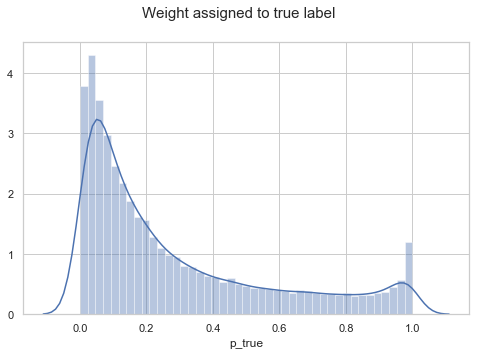

In [94]:
plt.figure(figsize=(8,5))
plt.suptitle('Weight assigned to true label', fontsize=15)
sns.distplot(df_test.p_true)
plt.savefig('figures/ptrue-all.png', bbox_inches='tight')

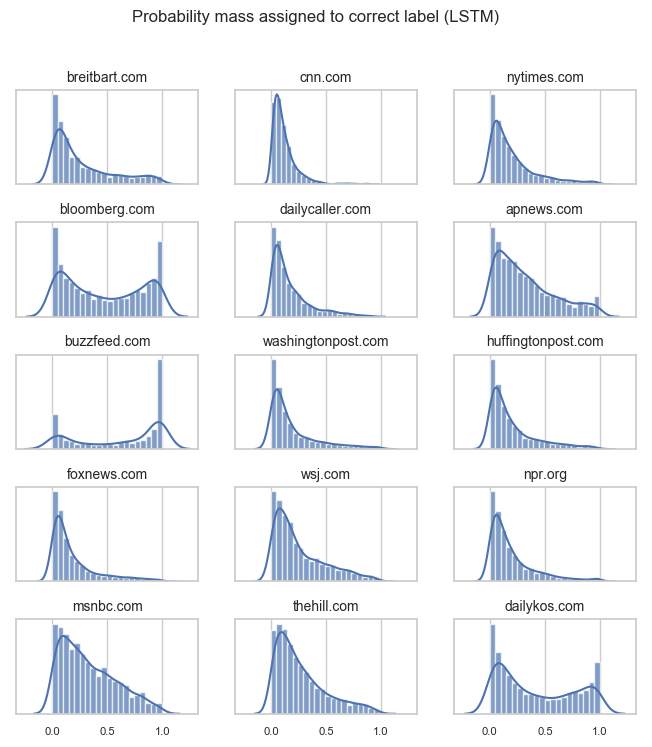

In [92]:
fig, axes = plt.subplots(5, 3, sharex=True, figsize=(8,8), dpi=100)

for i, d in enumerate(df.domain.unique()):
    ax = axes.reshape(-1)[i]
    ax.set_title(d, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_yticks([])
    sns.distplot(df_test[df_test.domain==d].p_true, bins=20, ax=ax, color='b', kde=True, hist_kws=dict(alpha=0.7))
    ax.set_xlabel(None)
    
fig.subplots_adjust(hspace=0.4, bottom=0.1)
plt.suptitle('Probability mass assigned to correct label (LSTM)')
plt.savefig('figures/ptrue-multiples.png', bbox_inches='tight')

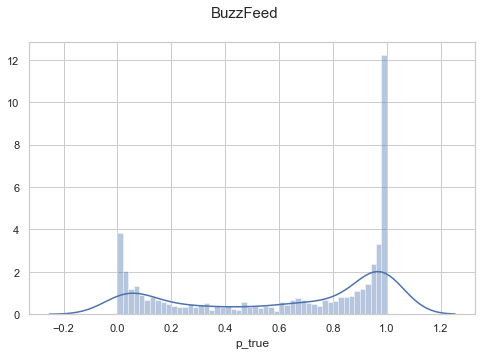

In [96]:
plt.figure(figsize=(8,5))
plt.suptitle('BuzzFeed', fontsize=15)
sns.distplot(df_test[df_test.domain=='buzzfeed.com'].p_true, bins=50)
plt.savefig('figures/ptrue-buzzfeed.png', bbox_inches='tight')

In [73]:
df.sort_values('p_true', ascending=False)[['domain', 'title', 'p_true', 'impressions']].head(10)

,domain,title,p_true,impressions
271201,buzzfeed.com,Which Underrated Disney Character Are You ?,0.999998,14087
131888,buzzfeed.com,Answer These Random Questions And We 'll Tell ...,0.999998,16218
129231,buzzfeed.com,Pick Some Disney Characters And We 'll Tell Yo...,0.999997,107112
148147,buzzfeed.com,People Are Insisting That Shania Twain And Har...,0.999995,6524325
46544,buzzfeed.com,Choose Some Desserts From Around The World And...,0.999995,14995
241078,buzzfeed.com,Which Marvel Movie Character Are You ?,0.999995,107934
29183,buzzfeed.com,Pick Some TV And Movie Characters And We 'll G...,0.999995,30661
160000,buzzfeed.com,Create The Perfect Fictional Team And We 'll R...,0.999995,88978
193883,buzzfeed.com,Pick Some Disney Characters And We 'll Tell Yo...,0.999994,10675
272670,buzzfeed.com,Answer These Five Questions And We 'll Tell Yo...,0.999994,10304


# p-true > 0.9

In [46]:
t10 = df[df.p_true > 0.9]
t10['tokens_key'] = t10.clf_tokens.apply(lambda ts: tuple(ts))
t10 = t10.drop_duplicates('tokens_key')

t10_embeds = embeds[t10.index]

dr = umap.UMAP(metric='cosine', verbose=True)
embedding = dr.fit_transform(t10_embeds)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


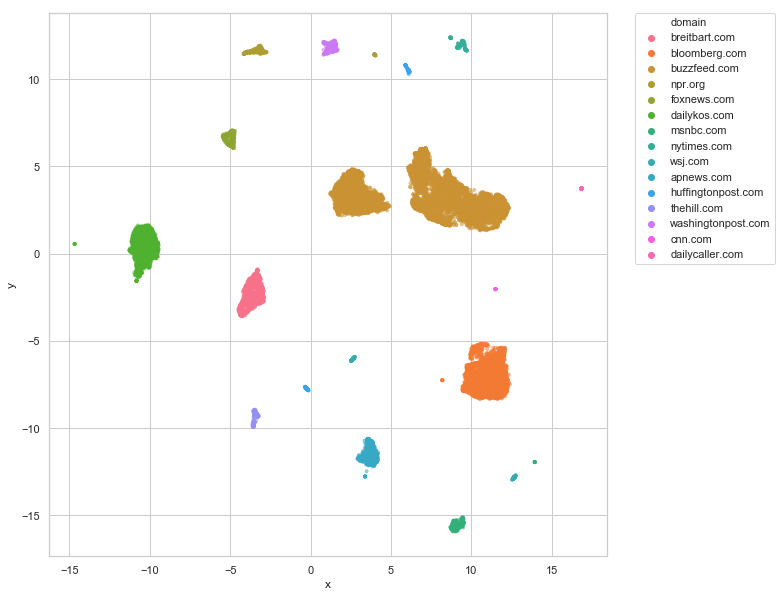

In [47]:
points = t10.copy()
points['x'] = embedding[:,0]
points['y'] = embedding[:,1]

points = points[['domain', 'label', 'p_true', 'x', 'y']]

plt.figure(figsize=(10,10))

sns.scatterplot(
    x='x', y='y',
    data=points,
    s=10,
    edgecolor=None,
    alpha=0.5,
    hue='domain',
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

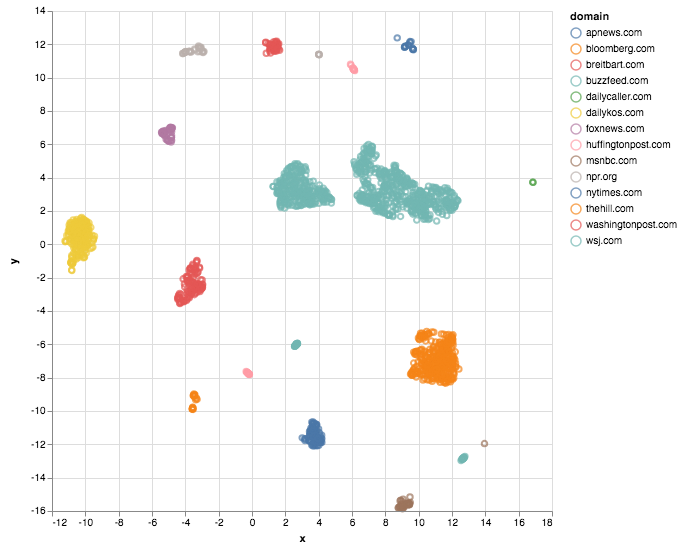

In [48]:
(alt
    .Chart(points.sample(frac=0.1), width=500, height=500)
    .mark_point()
    .encode(x='x', y='y', tooltip='label', color='domain'))